# Quantum Fourier Transform

QFT is a heuristic inspired from Fast Fourier Transform. It is an important subroutine for many quantum algorithms, like Quantum Phase Esimation.

QFT is an efficient algorithm to make a Fourier Transform in the amplitudes of the quantum states.

The implementation of the algorithm is based on the classic book Quantum Computatation and Quantum Information

In [12]:
import numpy as np
from qiskit import QuantumCircuit, execute
from qiskit.visualization import plot_histogram

# create quantum circtuit
circuit = QuantumCircuit(5, 5)

# start with a binary string 00111
circuit.x([2, 3, 4])

circuit.barrier()

QFT is a unitaty transformation which enables the transformation between amplitudes and states:

$$ \sum_{j=0}^{N-1} x_j \ket{j} \rightarrow \sum_{k=0}^{N-1} y_k \ket{k} $$
where basis j is tranformed to k by
$$ \ket{y} \rightarrow \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} e^{2 \pi i j k / N} \ket{k} $$

The QFT procedure is based in some notations like 

* Binary representation

$$ j = j_1j_2...j_n = j_1 2^{n-1} + ... + j_n 2^{0} $$

* Binary fraction

$$ 0.j_lj_{l+1}...j_m = \frac{j_l}{2} + \frac{j_{l+1}}{2^2} + ... + \frac{j_l}{2^{m-l+1}} $$

Starting with the amplitude and basis tranformation, we arrive in an interesting product representation

$$ \ket{y} \rightarrow \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} e^{2 \pi i j k / N} \ket{k} \\
\vdots \\
\ket{j_1...j_n} \rightarrow \frac{(\ket{0} + e^{2 \pi i 0.j_n} \ket{1}) \otimes (\ket{0} + e^{2 \pi i 0.j_{n-2}j_n} \ket{1}) \otimes ... \otimes (\ket{0} + e^{2 \pi i 0.j_1...j_n} \ket{1})}{2^{n/2}}
$$

For this product representation, there is an efficient algorithm to produce this state. It is based on Hadamard gate, swap gate and the unitary transformation:

$$ R_k = \begin{bmatrix}
1 & 0\\
0 & e^{2 \pi i / 2^k}
\end{bmatrix} $$

We will now define the function which implements this QFT transform, based on the previous 3 type of gates. Swaps between the qubits at the end of the rotations is required to product the product representation defined above

In [13]:
# define function for qft and invese qft
def qft(circuit, qubit_start, qubit_end) :
    # apply hadamard gate
    circuit.h(qubit_start)

    # start with phase power equal to 1
    phase_power = 1

    for qubit in range(qubit_start + 1, qubit_end + 1) :
        # apply controlled phase rotation gate
        circuit.cp(np.pi / 2**(phase_power), qubit_start, qubit, label = 'R')

        # increase phase power
        phase_power += 1


    qubit_start += 1

    # after applying rotations to n qubit, contine with the next qubit
    if qubit_start < qubit_end :
        # circuit.barrier()
        qft(circuit, qubit_start, qubit_end)
    else :
        circuit.h(qubit_start)

def swap_qubits(circuit, num_qubits) :
    for qubit in range(num_qubits // 2):
        circuit.swap(qubit, num_qubits - qubit - 1)

* For the current task, we will apply the QFT and also implement the inverse of QFT. 

The inverse of QFT is used in the Quantum Phase Estimation algorithm. And we will see conform with the inverse that QFT is actually a unitary, revertable transformation

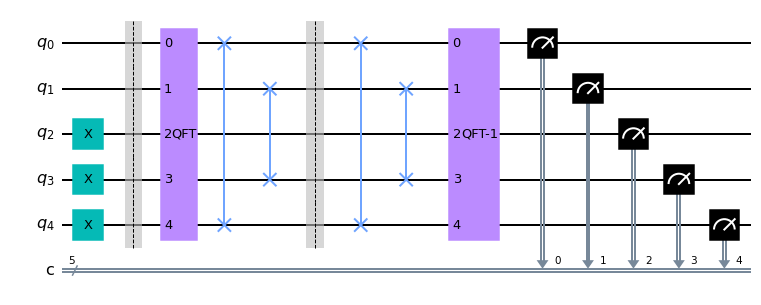

In [14]:
from qiskit.circuit.library import QFT

# apply qft 
qft_circ = QuantumCircuit(5)
qft(qft_circ, 0, 4)
circuit.compose(qft_circ.to_gate(label = 'QFT'), inplace = True)
swap_qubits(circuit, 5)

circuit.barrier()

# swap qubits
swap_qubits(circuit, 5)

# apply inverse qft to see if resetting is correct
inverse_circ = qft_circ.inverse()

# add inverse qft as a quantum gate in the circuit
circuit.compose(inverse_circ.to_gate(label = 'QFT-1'), inplace = True)

# measure all qubits
circuit.measure(range(5), range(5))

%matplotlib inline
circuit.draw(output = 'mpl')

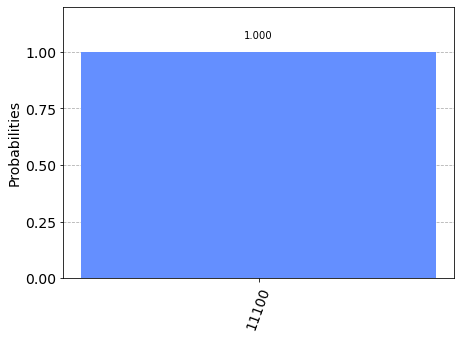

In [15]:
# simulate the circuit
from qiskit import Aer

simulator = simulator = Aer.get_backend('qasm_simulator')

result = execute(circuit, backend = simulator, shots = 1000).result()

counts = result.get_counts()

plot_histogram(counts)